In [7]:
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import commonfunctions as cf
import cv2
import numpy as np
import matplotlib.pyplot as plt


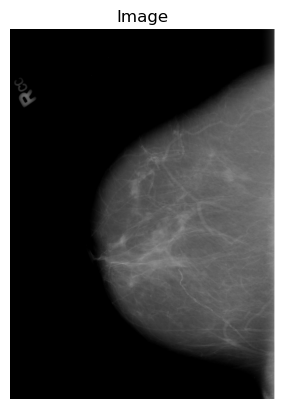

In [9]:
img = io.imread("jpeg/1.3.6.1.4.1.9590.100.1.2.499558611862523307025745211397332529/1-036.jpg")
show_images([img], ['Image'])


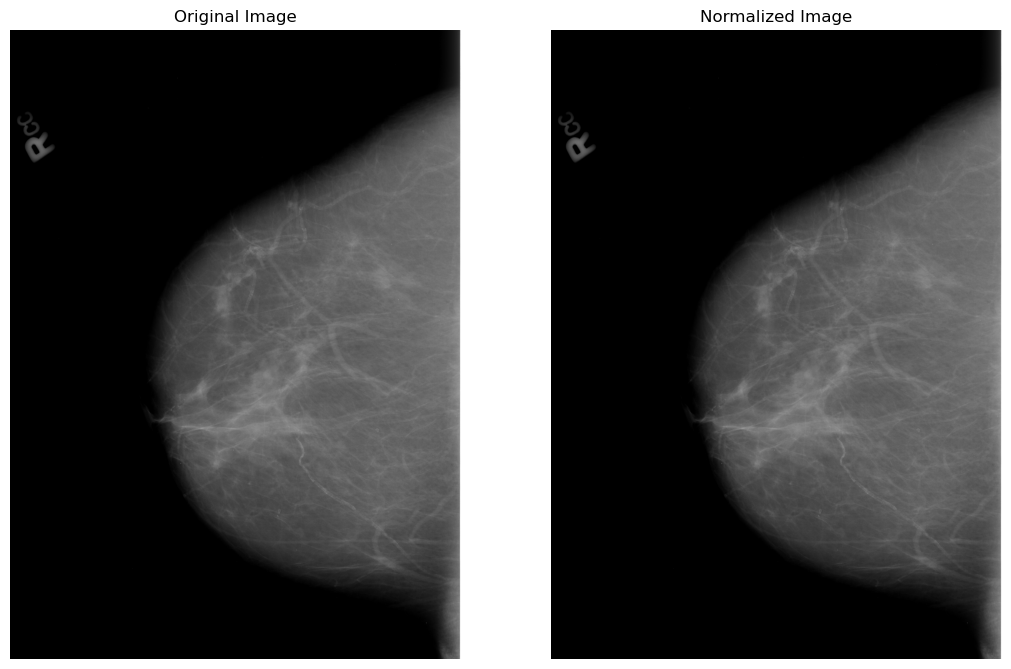

In [10]:
# Normalize to 0–255
img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

# Convert to uint8
img_uint8 = np.uint8(img_norm)
show_images([img, img_uint8], ['Original Image', 'Normalized Image'])

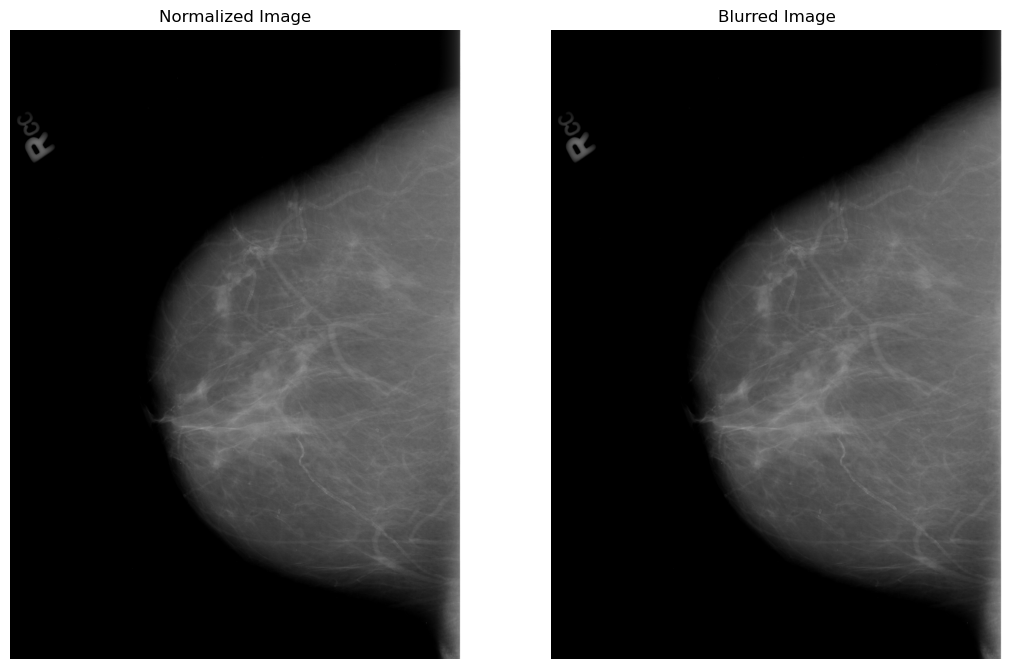

In [11]:

img_blur = cv2.GaussianBlur(img_uint8, (5, 5), 0)
show_images([img_uint8, img_blur], ['Normalized Image', 'Blurred Image'])

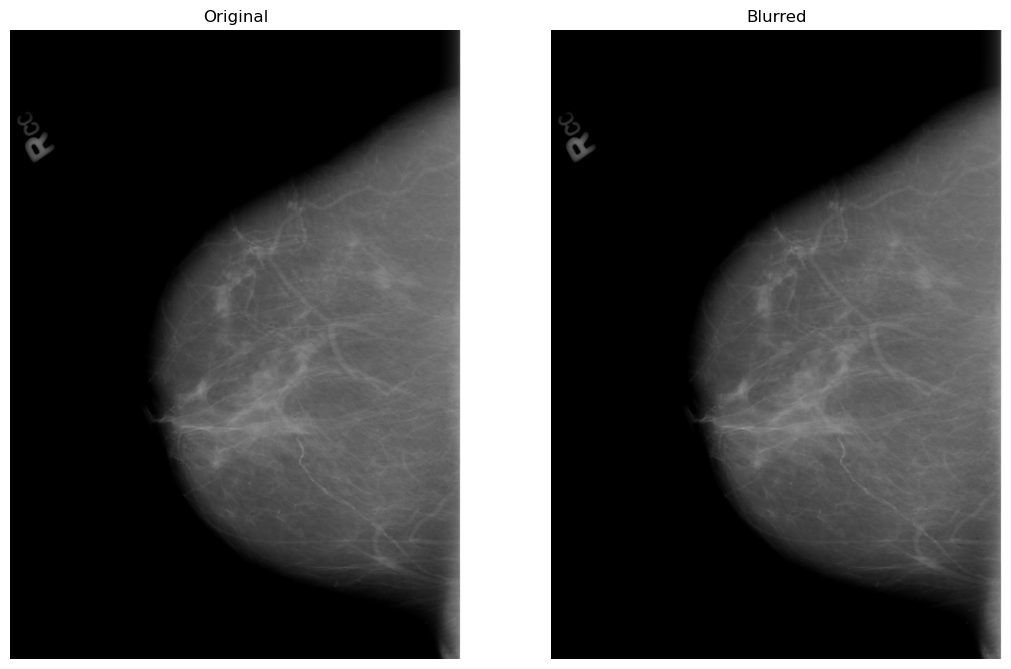

In [12]:
show_images([img_uint8, img_blur], ['Original', 'Blurred'])

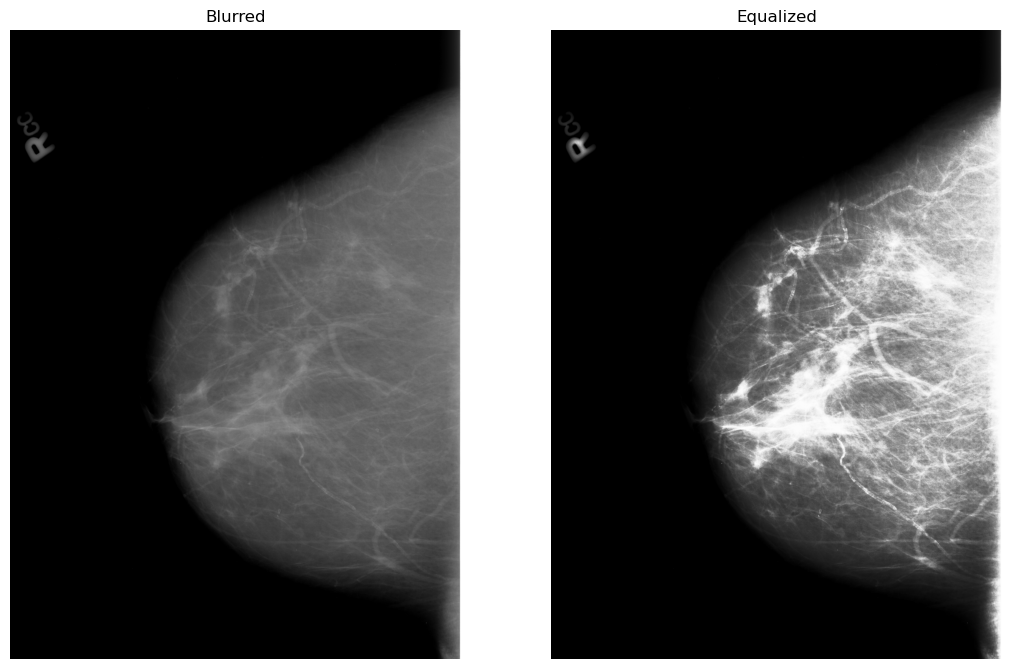

In [13]:
img_eq = cv2.equalizeHist(img_blur)
show_images([img_blur, img_eq], ['Blurred', 'Equalized'])

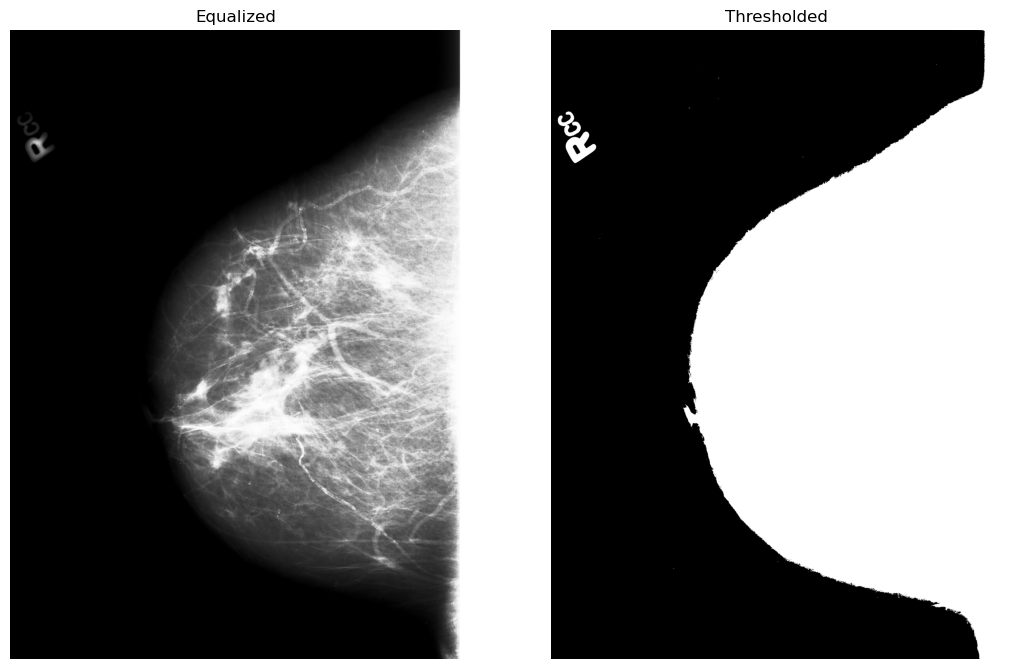

In [14]:
_, thresh = cv2.threshold(img_eq, 5, 255, cv2.THRESH_BINARY)
show_images([img_eq, thresh], ['Equalized', 'Thresholded'])

In [15]:
th = thresh.copy()
th = cv2.threshold(th, 127, 255, cv2.THRESH_BINARY)[1]

# Connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th, connectivity=8)

# stats = [label, x, y, width, height, area]

# Find the largest connected component (ignore background label 0)
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

# Create mask of only the largest component
clean_mask = np.zeros_like(th)
clean_mask[labels == largest_label] = 255

# (Optional) smooth mask edges
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel)

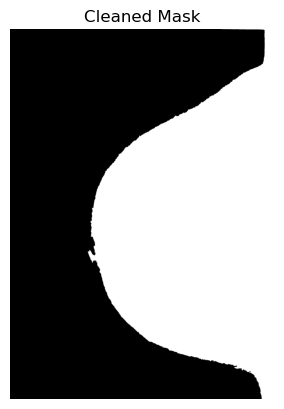

In [16]:
show_images([clean_mask], ['Cleaned Mask'])

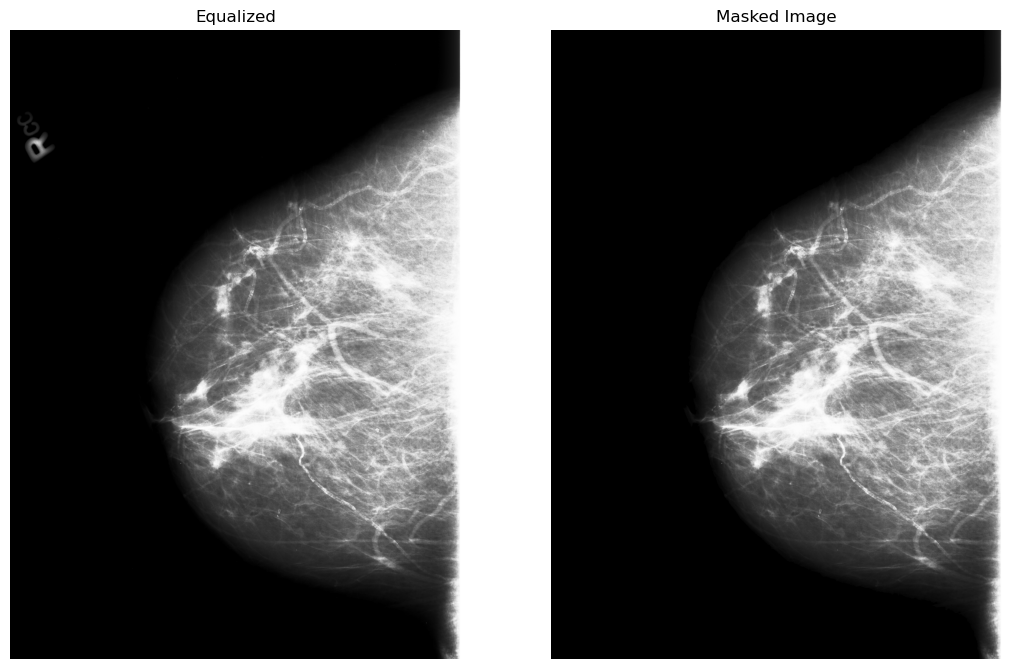

In [17]:
# Ensure clean_mask is 0/255
masked_img = cv2.bitwise_and(img_eq, img_eq, mask=clean_mask)
show_images([img_eq, masked_img], ['Equalized', 'Masked Image'])

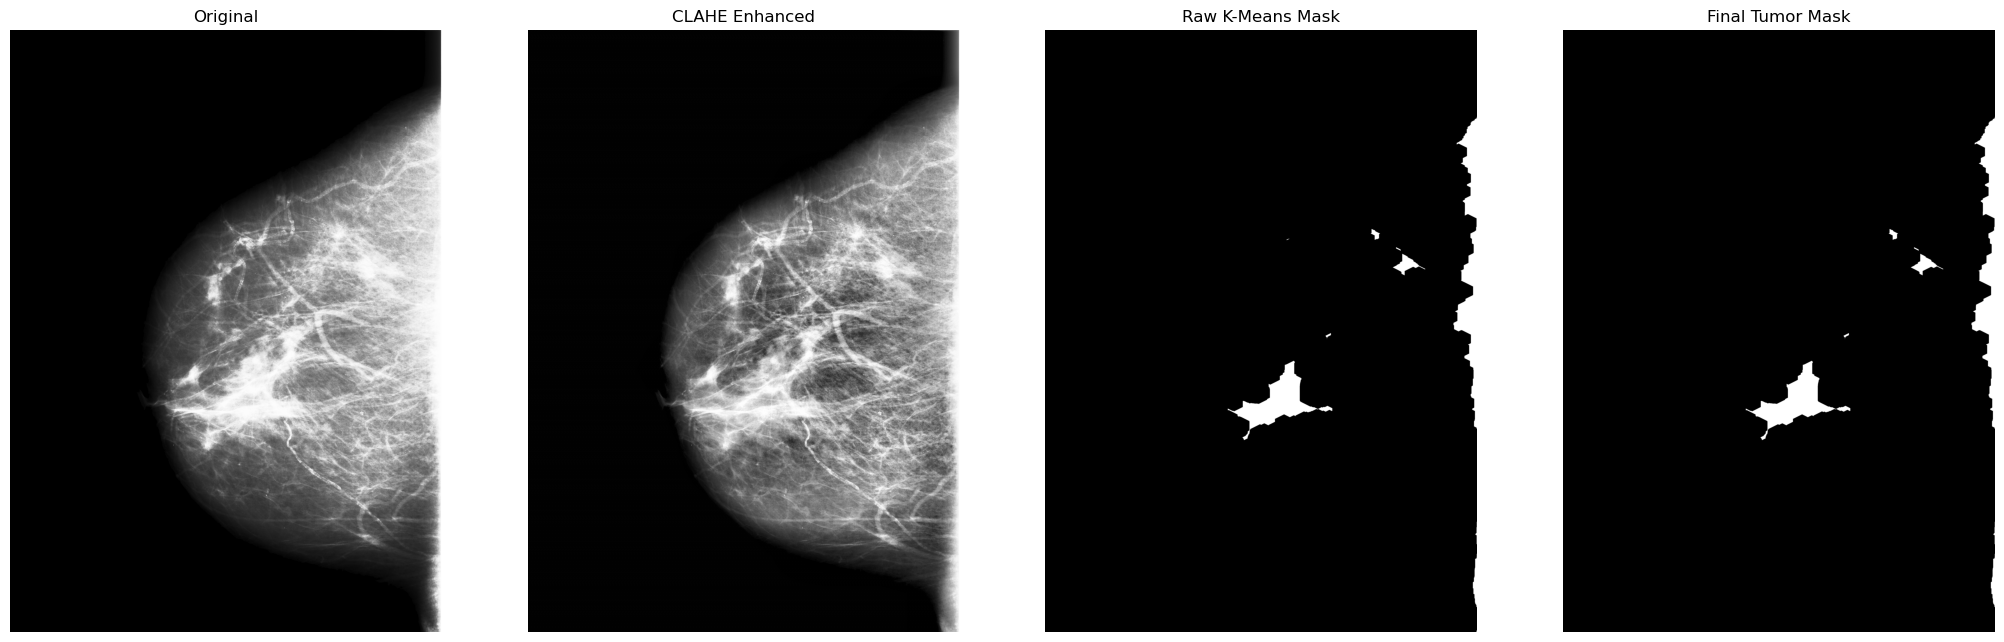

In [18]:
import cv2
import numpy as np

# =====================================================
# 1. CLAHE ENHANCEMENT
# =====================================================
# ClipLimit=4.0 is aggressive but good for dense masses
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
enhanced_img = clahe.apply(masked_img)

# =====================================================
# 2. K-MEANS CLUSTERING (INTENSITY SEPARATION)
# =====================================================
pixel_values = enhanced_img.reshape((-1, 1)).astype(np.float32)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
K = 3 # 1.Background, 2.Tissue, 3.Dense Mass + Muscle

_, labels, centers = cv2.kmeans(
    pixel_values, K, None, criteria, 10, cv2.KMEANS_PP_CENTERS
)

centers = np.uint8(centers)
segmented = centers[labels.flatten()]
segmented = segmented.reshape(masked_img.shape)

# =====================================================
# 3. EXTRACT BRIGHTEST CLUSTER (Raw Mask)
# =====================================================
# This mask likely contains BOTH the tumor and the muscle
bright_cluster_idx = np.argmax(centers)
candidate_mask = (segmented == centers[bright_cluster_idx]).astype(np.uint8) * 255

# =====================================================
# 4. MORPHOLOGICAL CLEANUP
# =====================================================
kernel_clean = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
candidate_mask = cv2.morphologyEx(candidate_mask, cv2.MORPH_OPEN, kernel_clean)
candidate_mask = cv2.morphologyEx(candidate_mask, cv2.MORPH_CLOSE, kernel_clean)
candidate_mask = cv2.erode(candidate_mask, kernel_clean, iterations=35)

# =====================================================
# 5. LOCATION FILTERING (The "What to do" part)
# =====================================================
# We need to distinguish the TUMOR (lower) from the MUSCLE (upper)
contours, _ = cv2.findContours(candidate_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

final_tumor_mask = np.zeros_like(candidate_mask)
height, width = candidate_mask.shape

for cnt in contours:
    area = cv2.contourArea(cnt)
    
    # 1. Filter small noise
    if area < 300: 
        continue

    # 2. Filter by Position (Remove Top Muscle)
    x, y, w, h = cv2.boundingRect(cnt)
    cy = y + h // 2  # Center Y of the blob
    
    # If the blob center is in the top 30% of the image, ignore it (it's muscle)
    if cy > (height * 0.3):
        cv2.drawContours(final_tumor_mask, [cnt], -1, 255, -1)

# =====================================================
# VISUALIZATION
# =====================================================
show_images(
    [masked_img, enhanced_img, candidate_mask, final_tumor_mask],
    ["Original", "CLAHE Enhanced", "Raw K-Means Mask", "Final Tumor Mask"]
)

Success: Mass detected (Area: 162138.0)


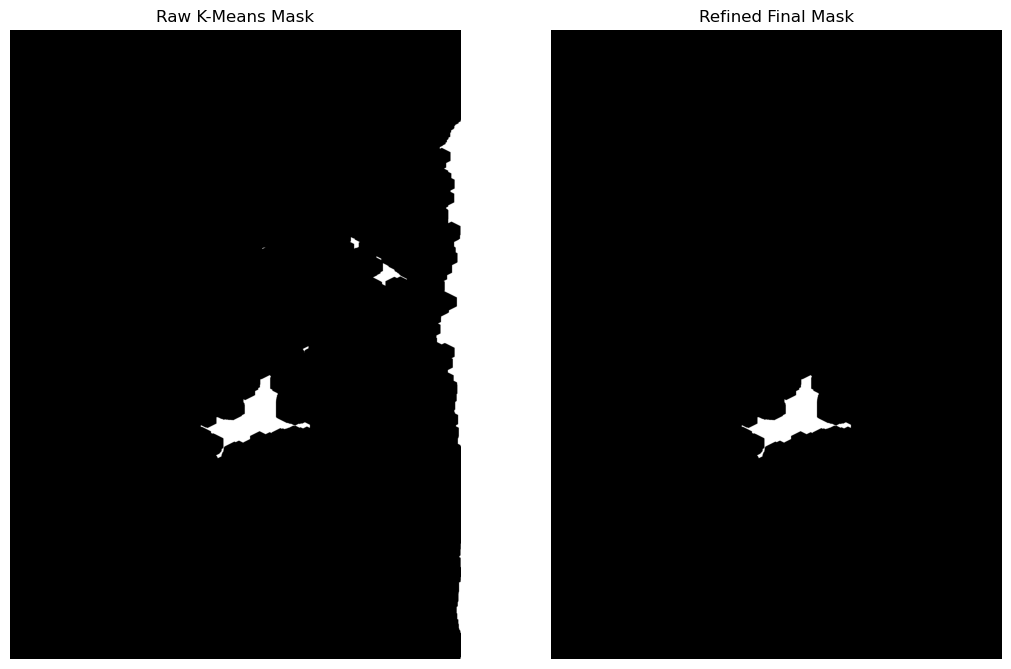

In [24]:
from skimage.measure import label, regionprops

# --- REFINEMENT WITH BORDER REJECTION ---

# 1. Label all connected blobs
label_img = label(candidate_mask)
regions = regionprops(label_img)

# Define a margin (in pixels). 
# Any blob within this distance from the edge will be ignored.
# Increase this if you still see edge artifacts (e.g., try 50, 80, or 100).
border_margin = 50 
height, width = candidate_mask.shape

valid_regions = []

for region in regions:
    # Get the bounding box of the blob
    min_row, min_col, max_row, max_col = region.bbox
    
    # CHECK: Is the blob fully inside the safe zone?
    # It must start after the margin AND end before the (limit - margin)
    if (min_row > border_margin and min_col > border_margin and 
        max_row < (height - border_margin) and max_col < (width - border_margin)):
        
        valid_regions.append(region)

# 2. Find the largest blob among the VALID ones
if valid_regions:
    # Sort by area and pick the largest
    largest_region = max(valid_regions, key=lambda r: r.area)
    
    # Create the final mask
    final_mask = np.zeros_like(candidate_mask)
    for r, c in largest_region.coords:
        final_mask[r, c] = 255
        
    print(f"Success: Mass detected (Area: {largest_region.area})")
    
else:
    print("Warning: All detected blobs were too close to the border or no blobs found.")
    # Fallback: return empty mask or original if you prefer
    final_mask = np.zeros_like(candidate_mask)

# Visualization
show_images(
    [candidate_mask, final_mask],
    ["Raw K-Means Mask", "Refined Final Mask"]
)

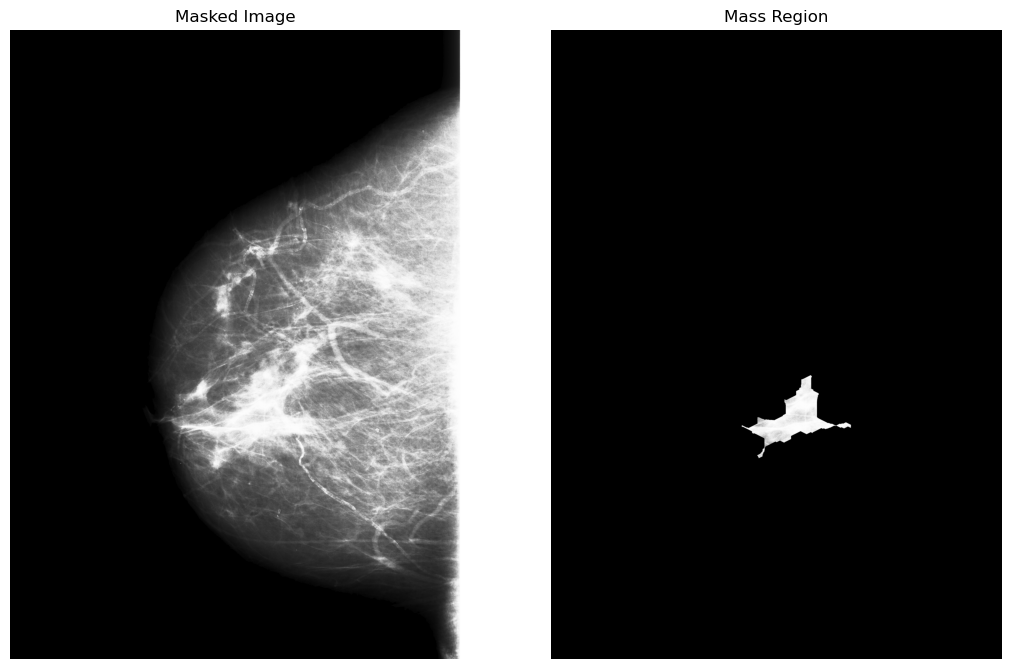

In [25]:
mass_region = cv2.bitwise_and(masked_img, masked_img, mask=final_mask)
show_images([masked_img, mass_region], ['Masked Image', 'Mass Region'])

In [26]:
from skimage.measure import label, regionprops
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def extract_features(mass_mask, original_img):
    # Label connected components in the mass mask
    label_img = label(mass_mask)
    regions = regionprops(label_img, intensity_image=original_img)

    if not regions:
        print("No mass region found for feature extraction.")
        return None

    # Assuming the largest region is the mass
    largest_region = max(regions, key=lambda r: r.area)
    
    features = {}
    
    # --- Shape Features ---
    features['Area'] = largest_region.area
    features['Perimeter'] = largest_region.perimeter
    features['Eccentricity'] = largest_region.eccentricity
    features['Solidity'] = largest_region.solidity
    features['Extent'] = largest_region.extent
    features['MajorAxisLength'] = largest_region.major_axis_length
    features['MinorAxisLength'] = largest_region.minor_axis_length

    # --- Texture Features using GLCM ---
    # We use the intensity image specific to the region (bounding box content)
    mass_region = largest_region.intensity_image
    
    # Normalize to 0-255 uint8 for GLCM
    if mass_region.max() > 0:
        mass_region = (mass_region * (255.0 / mass_region.max())).astype(np.uint8)
    else:
        mass_region = mass_region.astype(np.uint8)

    # Calculate GLCM (Gray-Level Co-occurrence Matrix)
    glcm = graycomatrix(mass_region, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    
    features['Contrast'] = graycoprops(glcm, 'contrast')[0, 0]
    features['Dissimilarity'] = graycoprops(glcm, 'dissimilarity')[0, 0]
    features['Homogeneity'] = graycoprops(glcm, 'homogeneity')[0, 0]
    features['Energy'] = graycoprops(glcm, 'energy')[0, 0]
    features['Correlation'] = graycoprops(glcm, 'correlation')[0, 0]
    features['ASM'] = graycoprops(glcm, 'ASM')[0, 0]

    return pd.DataFrame([features])

# Usage
# Ensure 'final_mask' and 'img_eq' are defined from previous steps
features_df = extract_features(final_mask, img_eq)

if features_df is not None:
    print(features_df)
    # Optional: Save to CSV
    # features_df.to_csv("mass_features.csv", index=False)

       Area    Perimeter  Eccentricity  Solidity    Extent  MajorAxisLength  \
0  162138.0  3241.763815      0.814732  0.494007  0.258597       724.944916   

   MinorAxisLength    Contrast  Dissimilarity  Homogeneity    Energy  \
0       420.350896  162.523619       1.018953     0.900249  0.740451   

   Correlation       ASM  
0     0.992584  0.548267  
